In [9]:
import sys
sys.path.append('../')
import helper

import numpy as np

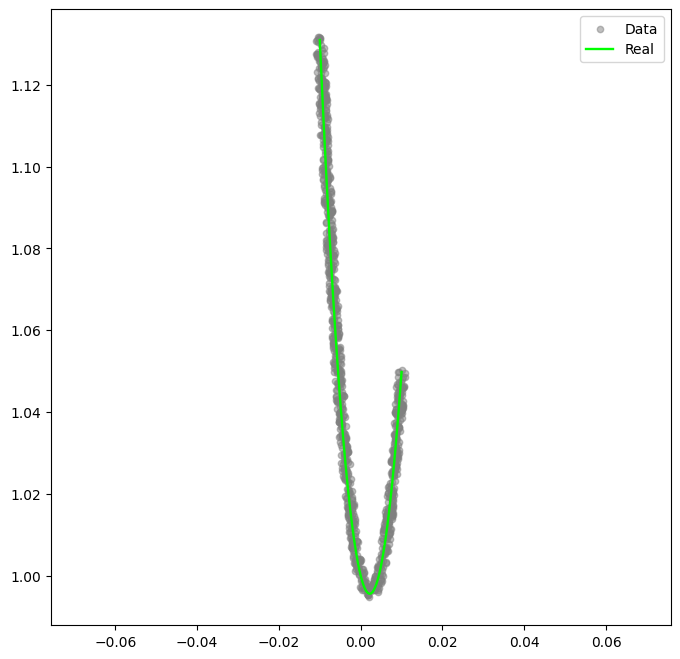

In [10]:
dataset_name = '1'
dataset_params = helper.get_params_dataset(dataset_name)
dataset_filename = helper.get_filenames_datasets()[dataset_name]
f = helper.get_func_research(dataset_params['f_label'])

X, Y, datasets = helper.load_datasets(dataset_filename)

helper.print_generated(X, Y, datasets[0])

real_w = np.array([dataset_params["w0"], dataset_params["w1"]], dtype=float)

In [11]:
import torch
import torch.optim as optim
import numpy as np
import math


# Определяем функцию потерь
def mse_loss(f, w, x_train, y_train):
    y_pred = f(x_train, w)
    mse = np.mean((y_train - y_pred) ** 2)
    return mse

def mse_loss_grad(f, w, x_train, y_train, batch_size, delta=1e-6):
    # Choose n random data points from the training set without replacement
    indices = np.random.choice(x_train.shape[0], batch_size, replace=False)
    X_batch = x_train[indices, :]
    y_batch = y_train[indices]
    n_features = len(w)
    grad = np.zeros(n_features, dtype=float)

    for i in range(n_features):
        w[i] += delta
        f_plus = mse_loss(f, w, X_batch, y_batch)
        w[i] -= delta
        w[i] -= delta
        f_minus = mse_loss(f, w, X_batch, y_batch)
        w[i] += delta
        grad[i] = np.divide(f_plus - f_minus, 2 * delta)

    return grad

def constant_lr_scheduling(epoch, initial_lr):
    return initial_lr


x_train, y_train = datasets[0][:, :-1], datasets[0][:, -1:]
eps_minimum = mse_loss(f, real_w, x_train, y_train)
eps_minimum = eps_minimum*1.1

# ================================================== RMSProp ==================================================== #

def custom_gradient_descent_with_lr_scheduling_and_RMSProp (
        f
        , x_train
        , y_train
        , eps_minimum
        , x0
        , batch_size=3
        , lr_scheduling_func=constant_lr_scheduling
        , initial_lr=1.0
        , num_iterations=10000
        , apply_min=True
        , apply_value=True
        , eps_RMSProp = 1e-8
):
    x = np.copy(x0)
    points = [x.copy()]
    value = 0.0
    G = eps_RMSProp

    if apply_value:
        value = mse_loss(f, x, x_train, y_train)

    for i in range(1, num_iterations):
        if apply_value:
            if apply_min and value < eps_minimum:
                break
        else:
            if apply_min and mse_loss(f, x, x_train, y_train) < eps_minimum:
                break

        grad_x = mse_loss_grad(f, x, x_train, y_train, batch_size)
        G = G*0.9 + (1 - 0.9) * (grad_x.dot(grad_x))
        new_x = x - grad_x * lr_scheduling_func(i, initial_lr) / (math.sqrt(G + eps_RMSProp))

        if apply_value:
            new_value = mse_loss(f, new_x, x_train, y_train)
            if new_value < value:
                x = new_x
                value = new_value
        else:
            x = new_x

        points.append(x.copy())

    return points

Real w: [2. 3.]
Обученные значения w: [1.81087849 2.99788956] steps: 614


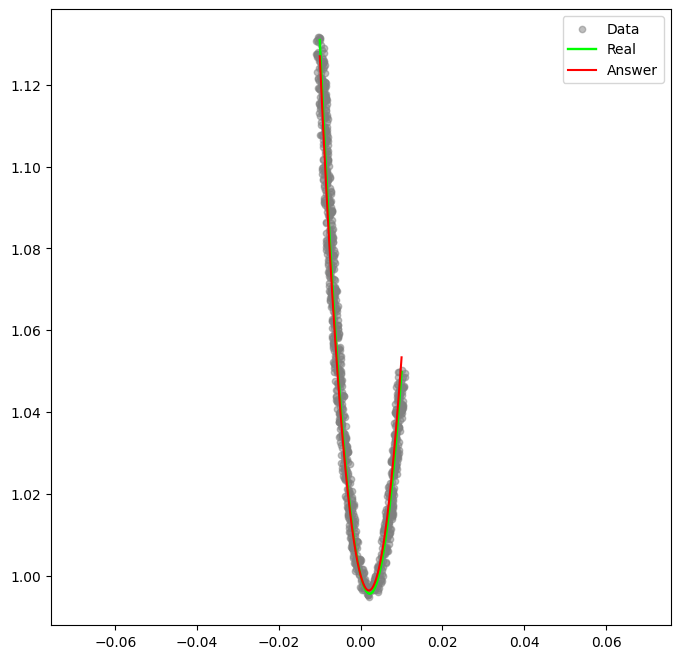

In [12]:
initial_w = np.array([-1.0, 0.1])
points = custom_gradient_descent_with_lr_scheduling_and_RMSProp(f, x_train, y_train, eps_minimum, initial_w, initial_lr=0.01)
print(f'Real w: {real_w}')
print("Обученные значения w:", points[-1], "steps:", len(points))
helper.print_generated(X, Y, datasets[0], f(X, points[-1]))